In [ ]:
import re
from collections import deque
from operator import and_, or_, xor
from pathlib import Path

operators = {
    "AND": and_,
    "OR": or_,
    "XOR": xor,
}


def eval_gate(input1: bool, input2: bool, operator: str) -> bool:
    """Evaluate a gate with two inputs and an operator."""
    return operators[operator](input1, input2)

In [ ]:
# Read input
wires = {}
gates = []

with Path("day24_input.txt").open() as file:
    for line in file:
        if init := re.match(r"(\w+): (\w+)", line.strip()):
            wires[init.group(1)] = int(init.group(2))
        if gate := re.match(r"(\w+) (\w+) (\w+) -> (\w+)", line.strip()):
            gates.append(gate.groups())

# Part 1


In [ ]:
# Simulate circuit
def simulate_circuit(wires, gates) -> None:
    """Simulate the circuit until all gates are resolved."""
    gates = deque(gates)
    while gates:
        gate = gates.popleft()
        input1, operator, input2, output = gate
        if input1 in wires and input2 in wires:
            wires[output] = eval_gate(wires[input1], wires[input2], operator)
        else:
            gates.append(gate)
    return wires


simulate_circuit(wires, gates)
bits = "".join(
    str(wires[wire]) for wire in sorted(wires, reverse=True) if wire.startswith("z")
)
print("Number: ", int(bits, 2))

# Part 2

A one-bit half-adder looks like this:

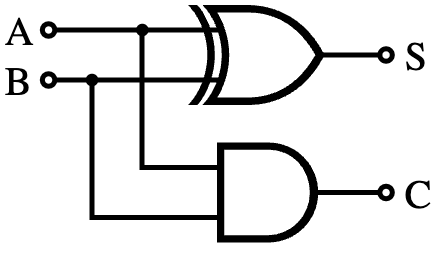

Where S is the sum and C is the carry-over. The value of the output is "2C + S".

In order to add two multi-bit numbers, we need to chain multiple full-adders. A full-adder looks like this:

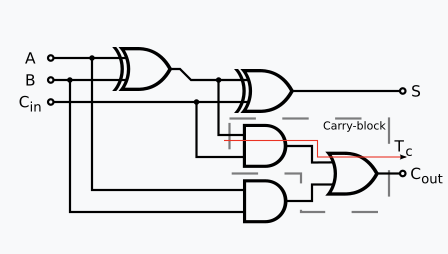

which can be written as:

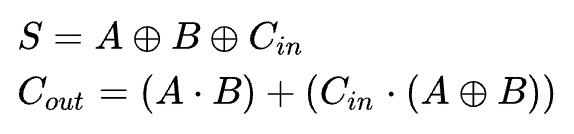

Chained together, a 4-bit adder would look like this:

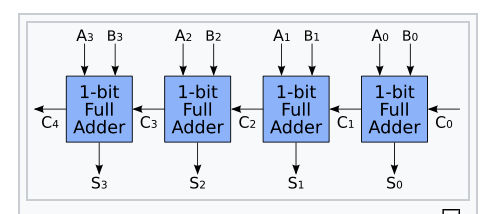

For the least significant bit, the carry-over is 0. Thus, the right-most adder can be replaced with a half-adder.


Thus, if the cicruit is to function as an adder, the following must be true:

$$
\begin{align}
C_0 & = 0 \\
Z_0 & = X_0 \oplus Y_0 \\
C_1 & = X_0 \land Y_0 \\
Z_1 & = X_1 \oplus Y_1 \oplus C_1 \\
\vdots \\
C_i & = (X_{i-1} \land Y_{i-1}) \lor (C_{i-1} \land (X_{i-1} \oplus Y_{i-1})) \\
Z_i & = X_i \oplus Y_i \oplus C_i \\
Z_{i+1} &= C_{i+1} = (X_{i} \land Y_{i}) \lor (C_{i} \land (X_{i} \oplus Y_{i})) \\
\end{align}
$$


Rules:

1. If the output is a z-wire, the operator MUST be an XOR, otherwise this output is
   wrong (except for the most significant bit of Z). See equations 7 and 8.
2. XOR is only allowed if the ouput is a z-wire, or the inputs are xy-wires. Otherwise,
   this output is wrong. See equations 6 and 7.
3. For each XOR-gate with xy-wires as inputs, the output of this gate must be an input
   another XOR gate. Except for the least significant bit. See equation 4.
4. For each AND-gate with xy-wires as inputs, the output of this gate must be an input
   to an OR gate. See equation 6.


In [ ]:
wrong_outputs = set()

for gate in gates:
    input1, operator, input2, output = gate

    # Rule 1:
    if output.startswith("z") and operator != "XOR":
        if output == "z45":
            continue
        print("Rule 1, wrong gate:", gate)
        wrong_outputs.add(output)

    # Rule 2:
    if operator == "XOR" and (
        not output.startswith("z") and sorted([input1[0], input2[0]]) != ["x", "y"]
    ):
        print("Rule 2, wrong gate:", gate)
        wrong_outputs.add(output)

    # Rule 3:
    if operator == "XOR" and sorted([input1[0], input2[0]]) == ["x", "y"]:
        if output == "z00":
            continue
        for next_gate in gates:
            next_input1, next_operator, next_input2, _ = next_gate
            if next_operator == "XOR" and (
                next_input1 == output or next_input2 == output
            ):
                # We found the XOR gate
                break
        else:
            print("Rule 3, wrong gate:", gate)
            wrong_outputs.add(output)

    # Rule 4:
    if operator == "AND" and sorted([input1[0], input2[0]]) == ["x", "y"]:
        if sorted([input1, input2]) == ["x00", "y00"]:
            continue
        for next_gate in gates:
            next_input1, next_operator, next_input2, _ = next_gate
            if next_operator == "OR" and (
                next_input1 == output or next_input2 == output
            ):
                # We found the OR gate
                break
        else:
            print("Rule 4, wrong gate:", gate)
            wrong_outputs.add(output)

In [ ]:
",".join(sorted(wrong_outputs))